In [1]:
import matplotlib.pyplot as pyplot
import matplotlib.animation as animation
import numpy as np
import random

**Caustics** Here we attempt to render the effect of light rays refracting through a water surface perturbed by waves.  Starting with a wave equation defining a cumulative displacement $z$ at point $\bar p$ and time $t$ from a number $n$ of frequencies $f_i$ of wave with velocity $v_i$, amplitude $a_i$ and phase $theta_i$, 

$$
z(\bar p,t) = \sum_{i=0}^n a \sin [ 2 \pi ( (\bar p-v_i*t)*f_i + \theta_i)  ]
$$
or in discrete coordinates $\bar p = (x,y)$:
$$
z(x,y,t) = \sum_{i=0}^n a \sin [ 2 \pi ( (x-v_i*t)*f_i + (y-v_i*t)*f_i + \theta_i)  ]
$$

To calculate the wave equation in numpy without a loop, we take the the x and y arrays passed in by *fromfunction()* and repeat each element *waves* times, then use a *sum()* over this extra dimension after calculation.

To calculate the caustics, we calculate the fraction of light cast by each square on the surface (x1, x2, y1, y2) cast onto a rectangle on the bottom (bx1, bx2, by1, by2).  Consider just the x-axis, the fraction of range (sx1,sx2) cast onto bottom pixel (bx1,bx2) falls into 6 categories:

1. sx2 < bx1: 0

2. sx1<bx1 & bx1<sx2<bx2: (sx2-bx1)/(sx2-sx1)

3. bx1<sx1<bx2 & bx1<sx2<bx2: 1

4. sx1<bx1 & bx2<sx2: (bx2-bx1)/(sx2-sx1)

5. bx1<sx1<bx2 & bx2<sx2: (bx2-sx1)/(sx2-sx1)

6. sx1 > bx2: 0

1,2 and 4 simplify to:

if sx1<bx1 then: max(min(sx2,bx2)-bx1,0)/(sx2-sx1)

3,5 and 6 simplify to:

else: min(max(bx2-sx1,0)/(sx2-sx1),1)

We then sum the contributions of the illumination on each bottom pixel.  To use what we assume are high efficiency numpy multiarrays rather than Python we *repeat* each sx,sy pixel for each bx,by bottom pixel giving a 4D array then apply the rule above and sum.

In [2]:
#test the simplifications above
def illuminate(sx1,sx2,bx1,bx2):
    if sx1<bx1: return max(min(sx2,bx2)-bx1,0)/(sx2-sx1) 
    else: return min(max(bx2-sx1,0)/(sx2-sx1),1)
assert(abs(illuminate(0,1, 2,3)-0)<1e-10)
assert(abs(illuminate(0.3,2.3, 2,3)-0.15)<1e-10)
assert(abs(illuminate(0.3,5.3, 2,3)-0.2)<1e-10)
assert(abs(illuminate(2.3,2.5, 2,3)-1)<1e-10)
assert(abs(illuminate(2.2,5.4, 2,3)-0.25)<1e-10)
assert(abs(illuminate(3.0,3.3, 2,3)-0)<1e-10)

In [6]:
width = height = 50
shape=(width,height)
frequencies = 8
np.random.seed(0)
amplitudes = np.random.uniform(0,0.5,(frequencies))
for i in range(0,int(frequencies/2)): amplitudes[i] = amplitudes[i+frequencies/2]
#print(amplitudes)
velocity = np.random.uniform(0,0.5,(frequencies))
for i in range(0,int(frequencies/2)): velocity[i] = -velocity[i+frequencies/2]
phases = np.random.uniform(0,1,(frequencies))
maxfreq = 3
freqx = np.random.uniform(-maxfreq,maxfreq,(frequencies))
for i in range(0,int(frequencies/2)): freqx[i] = -freqx[i+frequencies/2]
freqy = np.random.uniform(-maxfreq,maxfreq,(frequencies))
for i in range(0,int(frequencies/2)): freqy[i] = -freqy[i+frequencies/2]
i = np.array(range(0,frequencies))

def wave(x,y,t):
    #print(x,y,t)
    xx=x.repeat(frequencies).reshape(width, height, frequencies)
    yy=y.repeat(frequencies).reshape(width, height, frequencies)
    surface = (amplitudes * np.sin(((xx-velocity*t)*freqx + (yy-velocity*t)*freqy + phases)*np.pi*2)).sum(axis=2)
    #print(surface)
    depth = 3
    
    bx1 = x[:-2,:-2].repeat((width-2)*(height-2)).reshape(width-2, height-2, width-2, height-2).swapaxes(0,2).swapaxes(1,3)
    bx2 = x[:-2,1:-1].repeat((width-2)*(height-2)).reshape(width-2, height-2, width-2, height-2).swapaxes(0,2).swapaxes(1,3)

    sx = (surface[1:,:-1]-surface[:-1,:-1])*depth + x[:-1,:-1]
    sxr = sx.repeat((width-2)*(height-2)).reshape(width-1, height-1, width-2, height-2)
    sxr1 = sxr[:-1,:-1,:,:]
    sxr2 = sxr[1:,1:,:,:]
    sx1 = np.minimum(sxr1, sxr2)
    sx2 = np.maximum(sxr1, sxr2)

    by1 = y[:-2,:-2].repeat((width-2)*(height-2)).reshape(width-2, height-2, width-2, height-2).swapaxes(0,2).swapaxes(1,3)
    by2 = y[1:-1,:-2].repeat((width-2)*(height-2)).reshape(width-2, height-2, width-2, height-2).swapaxes(0,2).swapaxes(1,3)
    sy = (surface[:-1,1:]-surface[:-1,:-1])*depth + y[:-1,:-1]
    syr = sy.repeat((width-2)*(height-2)).reshape(width-1, height-1, width-2, height-2)
    syr1 = syr[:-1,:-1,:,:]
    syr2 = syr[1:,1:,:,:]
    sy1 = np.minimum(syr1, syr2)
    sy2 = np.maximum(syr1, syr2)
    #print(sy1)

    caustic = ((sx1<bx1)*np.maximum(np.minimum(sx2,bx2)-bx1,0)/(sx2-sx1)) + ((sx1>=bx1)*np.minimum(np.maximum(bx2-sx1,0)/(sx2-sx1),1))
    caustic *= ((sy1<by1)*np.maximum(np.minimum(sy2,by2)-by1,0)/(sy2-sy1)) + ((sy1>=by1)*np.minimum(np.maximum(by2-sy1,0)/(sy2-sy1),1))
    caustic = caustic.sum(axis=(2,3))
    return caustic

def update(frame_number):
    im.set_array(np.fromfunction(lambda r,c:wave(c/width,r/height,frame_number/100), shape))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


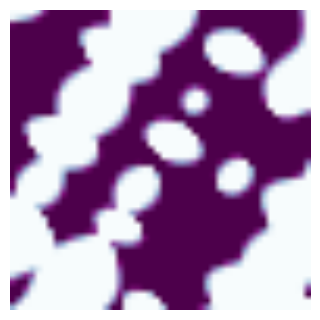

In [7]:
# Create new Figure and an Axes which fills it. 
fig = pyplot.figure(figsize=(3,3))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.random.uniform(0,1,shape), cmap="BuPu")
anim = animation.FuncAnimation(fig, update, interval=10)
pyplot.show()